In [62]:
import os
os.chdir(os.getenv("WORKINGDIR"))
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skipper_image_analysis.utils import (
    plot_ccd_image, correct_overscan, get_rowcol_ovserscan
)
from scipy.optimize import curve_fit

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

def gaussiana(x, mu, sigma, a):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

sgn_files = {
    "0film": {
        0.10: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.1_img20.fits",
        0.25: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img23.fits",
        0.50: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.5_img26.fits",
        0.75: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img29.fits",
        1.00: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img32.fits",
        1.25: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.25_img35.fits",
    },
    "1film": {
        0.25: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img7.fits",
        0.75: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img10.fits",
        2.50: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE2.5_img28.fits",
        5.00: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE5.0_img31.fits",
    },
    "2film": {
        1.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img13.fits",
        2.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE2.0_img16.fits",
        4.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE4.0_img19.fits",
        8.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE8.0_img22.fits",
        16.0: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE16.0_img25.fits",
    },
}
bkg_files = {
    "0film": {
        0.10: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.1_img19.fits',
        0.25: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img22.fits',
        0.50: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.5_img25.fits',
        0.75: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img28.fits',
        1.00: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img31.fits',
        1.25: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.25_img34.fits',
    },
    "1film": {
        0.25: 'proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img6.fits',
        0.75: 'proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img9.fits',
        2.50: "proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE2.5_img27.fits",
        5.00: "proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE5.0_img30.fits",
    },
    "2film": {
        1.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img12.fits',
        2.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE2.0_img15.fits',
        4.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE4.0_img18.fits',
        8.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE8.0_img21.fits',
        16.0: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE16.0_img24.fits',
    },
}
GANANCIA = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

EXP_TIMES_NORM = LogNorm(0.1, 16)
EXP_TIME_CMAP = plt.cm.ScalarMappable(EXP_TIMES_NORM, "jet")

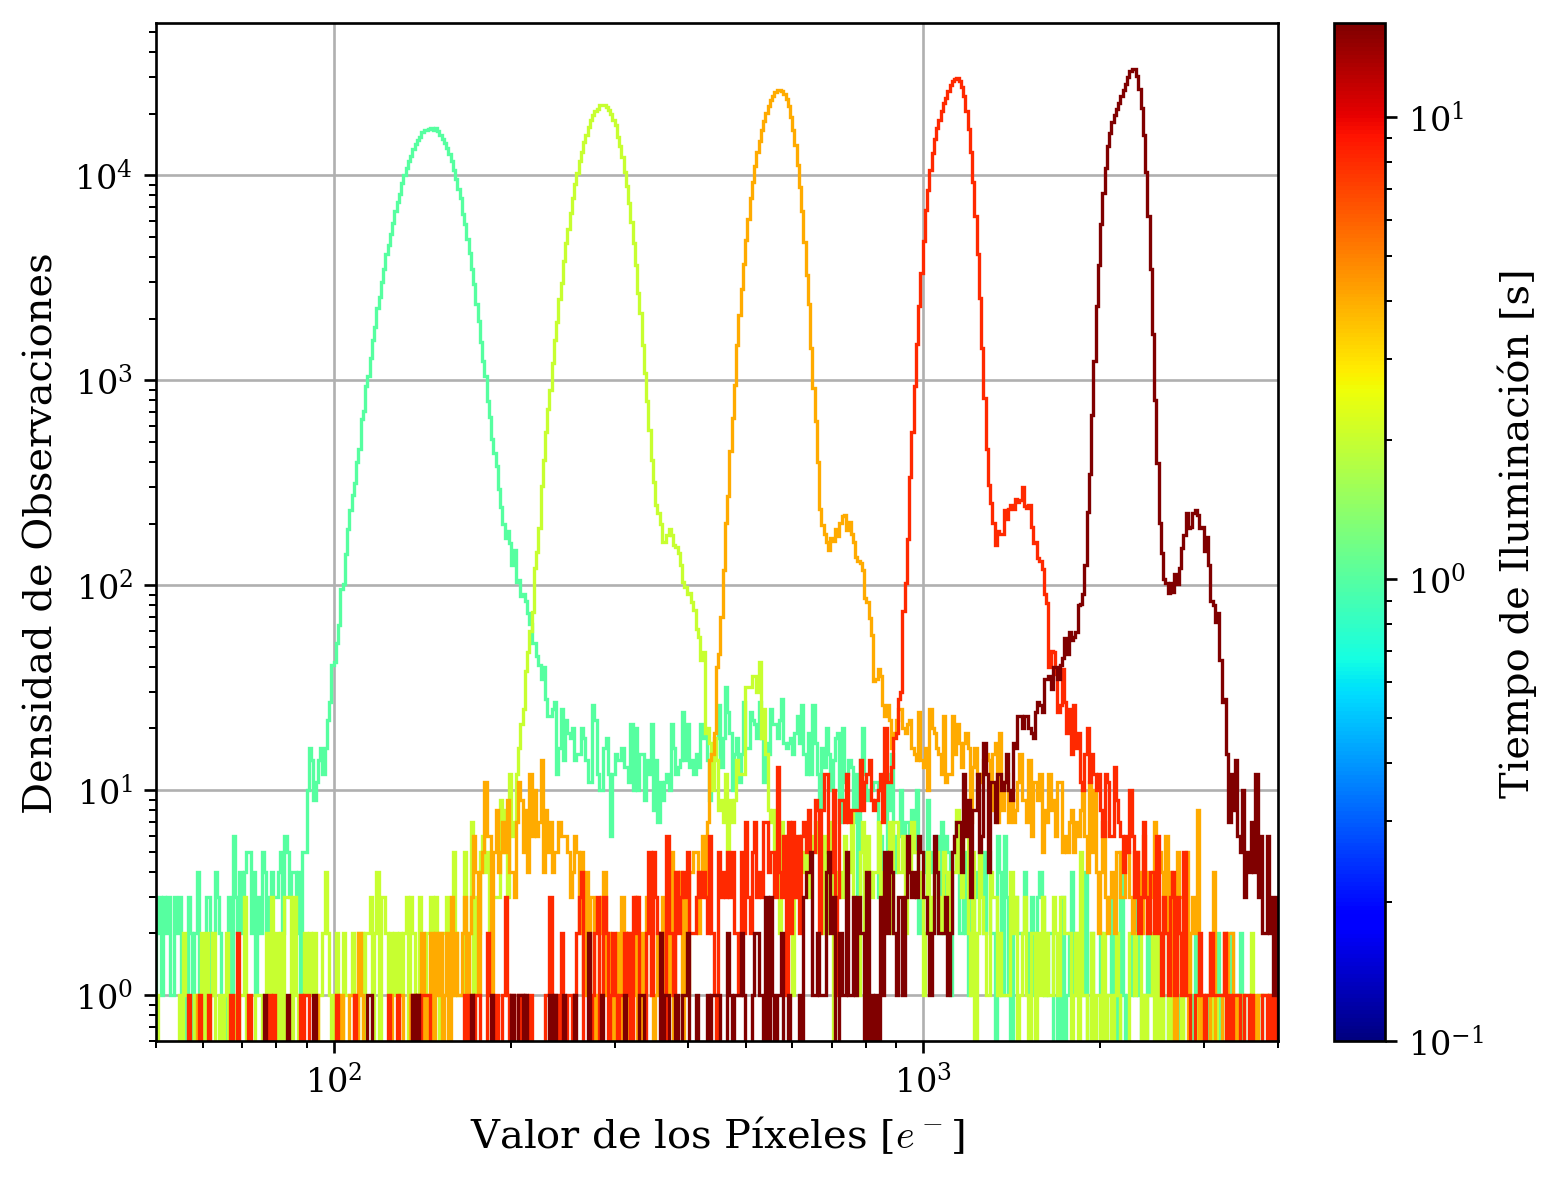

In [64]:
nfilms = 2
if nfilms == 0:
    data_dir = 'skipper_data/TRAPS/19OCT2023'
elif nfilms in [1, 2]:
    data_dir = 'skipper_data/TRAPS/26OCT2023'


min_val = 50  # e⁻
tope = 4000  # e⁻
n_bins = 500
exposure_times = np.array(list(sgn_files[f"{nfilms}film"].keys()))

fig, ax = plt.subplots(1, 1, constrained_layout=True)
carga_media = []
ancho_dist = []
for exp_time in exposure_times:
    lighted_image = fits.open(f'{data_dir}/{sgn_files[f"{nfilms}film"][exp_time]}')
    lighted_image = correct_overscan(lighted_image)
    background_image = fits.open(f'{data_dir}/{bkg_files[f"{nfilms}film"][exp_time]}')
    background_image = correct_overscan(background_image)
    r_overscan, c_overscan = get_rowcol_ovserscan(lighted_image)
    test_data = []
    for frame_idx in [0, 1]:
        test_frame = lighted_image[frame_idx].data - background_image[frame_idx].data
        test_frame = test_frame[:-r_overscan, PRESCAN_PIX:-c_overscan].flatten()  / GANANCIA[frame_idx]
        test_data.append(test_frame)
    test_data = np.concatenate(test_data)
    if nfilms in [1, 2]:
        lower_edge = test_data.mean() - 3*test_data.std()
        upper_edge = test_data.mean() + 3*test_data.std()
        cuentas, valores = np.histogram(test_data, bins=np.linspace(lower_edge, upper_edge, n_bins))
        popt, pcov = curve_fit(gaussiana, valores[:-1], cuentas, p0=[test_data.mean(), test_data.std(), cuentas.max()])
        carga_media.append(popt[0])
        ancho_dist.append(popt[1])
    else:
        carga_media.append(test_data.mean())
        ancho_dist.append(test_data.std())
    
    
    if min_val is None:
        min_val = np.nanmin(test_data)
    if tope is None:
        tope = np.nanmax(test_data)
    cuentas, valores, _ = ax.hist(
        test_data[
            (test_data > min_val)
            & (test_data < tope)
        ],
        bins=np.geomspace(min_val, tope, n_bins),
        histtype="step",
        color=EXP_TIME_CMAP.to_rgba(exp_time),
        label=f"{exp_time} s",
        # density=True,
    )

ax.grid(True)
plt.colorbar(
    EXP_TIME_CMAP, label="Tiempo de Iluminación [s]", ax=ax,
    # orientation="horizontal", location="top",
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(min_val, tope)
ax.set_xlabel("Valor de los Píxeles [$e^-$]")
ax.set_ylabel("Densidad de Observaciones")

plt.show()

Relación entre Carga Media y Ancho de la Distribución
Pendiente: 0.2 ± 0.007 e⁻/s
Ordenada : 32.5 ± 1e+01 e⁻
Relación entre Carga Media y Ancho de la Distribución
Pendiente: 0.1 ± 8e-05 e⁻/s
Ordenada : 3.6 ± 0.08 e⁻
Relación entre Carga Media y Ancho de la Distribución
Pendiente: 0.0 ± 0.0002 e⁻/s
Ordenada : 7.3 ± 0.3 e⁻


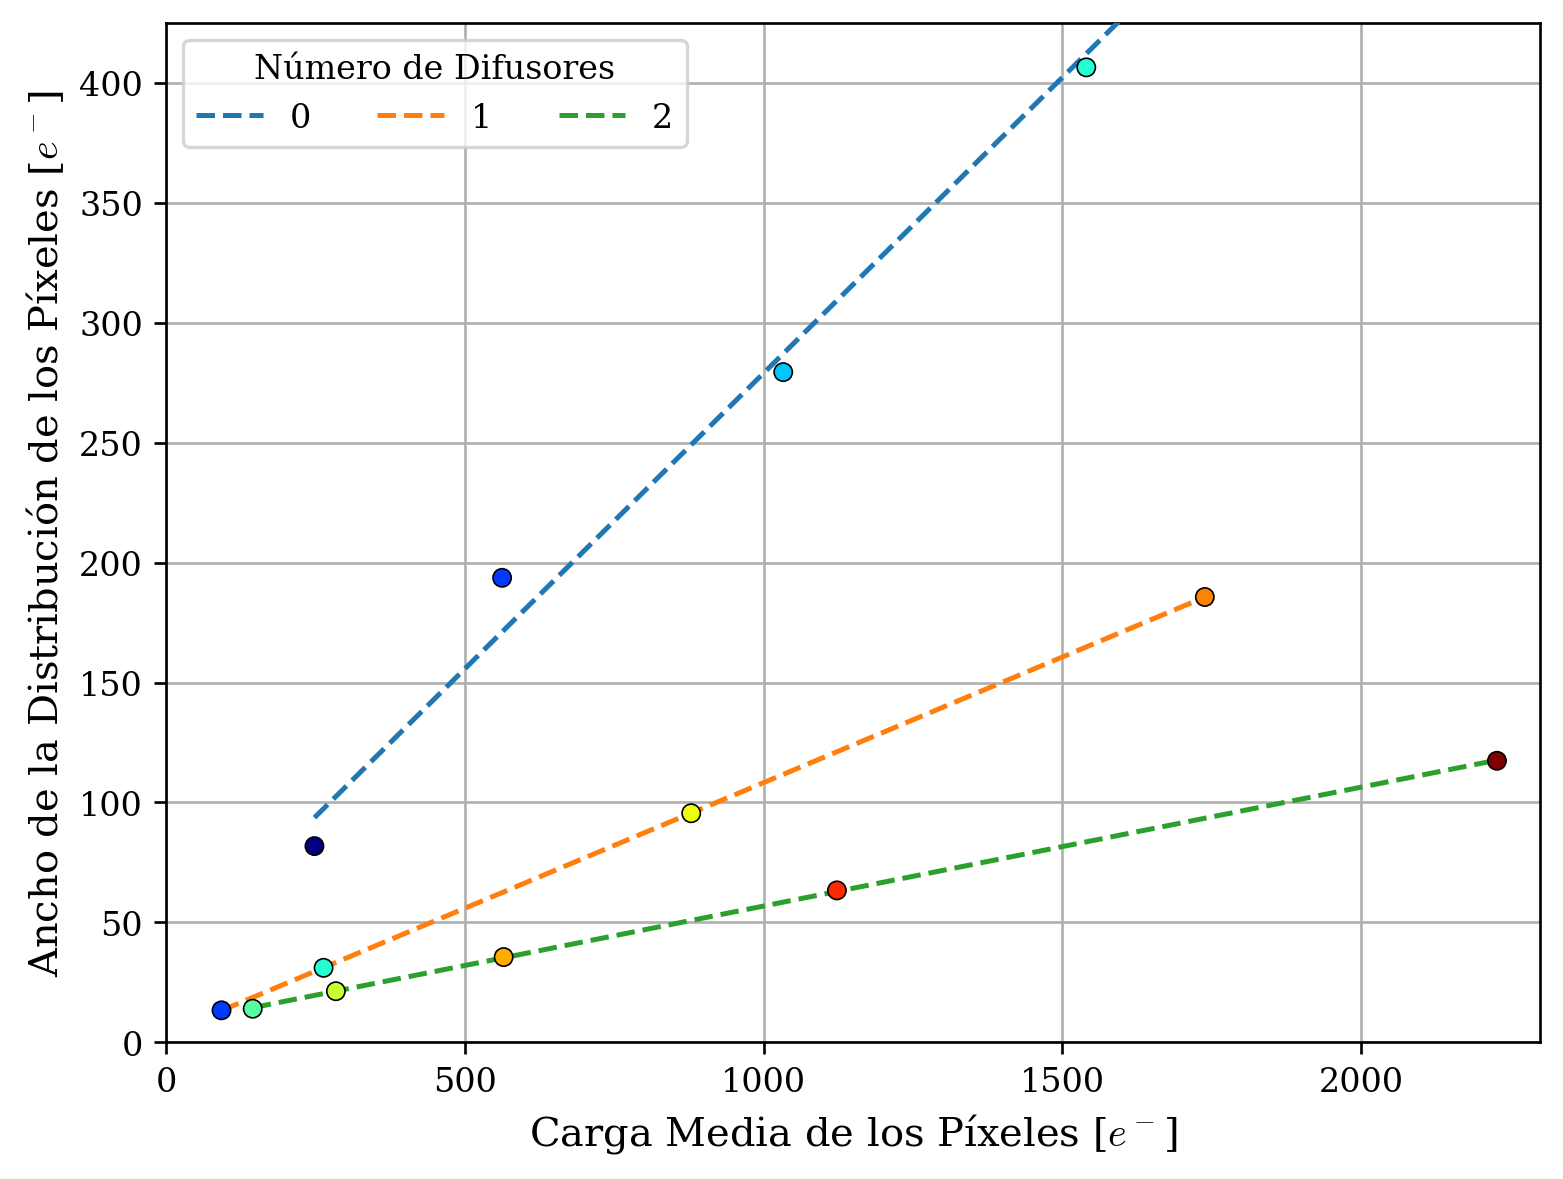

In [93]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)

for nfilms in [0, 1, 2]:
    if nfilms == 0:
        data_dir = 'skipper_data/TRAPS/19OCT2023'
    elif nfilms in [1, 2]:
        data_dir = 'skipper_data/TRAPS/26OCT2023'


    min_val = 50  # e⁻
    tope = 4000  # e⁻
    n_bins = 500
    exposure_times = np.array(list(sgn_files[f"{nfilms}film"].keys()))

    carga_media = []
    error_media = []
    ancho_dist = []
    for exp_time in exposure_times:
        lighted_image = fits.open(f'{data_dir}/{sgn_files[f"{nfilms}film"][exp_time]}')
        lighted_image = correct_overscan(lighted_image)
        background_image = fits.open(f'{data_dir}/{bkg_files[f"{nfilms}film"][exp_time]}')
        background_image = correct_overscan(background_image)
        r_overscan, c_overscan = get_rowcol_ovserscan(lighted_image)
        test_data = []
        for frame_idx in [0, 1]:
            test_frame = lighted_image[frame_idx].data - background_image[frame_idx].data
            test_frame = test_frame[:-r_overscan, PRESCAN_PIX:-c_overscan].flatten()  / GANANCIA[frame_idx]
            test_data.append(test_frame)
        test_data = np.concatenate(test_data)
        if nfilms in [1, 2]:
            lower_edge = test_data.mean() - 3*test_data.std()
            upper_edge = test_data.mean() + 3*test_data.std()
            cuentas, valores = np.histogram(test_data, bins=np.linspace(lower_edge, upper_edge, n_bins))
            popt, pcov = curve_fit(gaussiana, valores[:-1], cuentas, p0=[test_data.mean(), test_data.std(), cuentas.max()])
            perr = np.sqrt(np.diag(pcov))
            carga_media.append(popt[0])
            error_media.append(perr[0])
            ancho_dist.append(popt[1])
        else:
            carga_media.append(test_data.mean())
            error_media.append(test_data.std() / np.sqrt(len(test_data)))
            ancho_dist.append(test_data.std())
            
            


    ax.scatter(carga_media, ancho_dist, c=EXP_TIME_CMAP.to_rgba(exposure_times),
               s=30, edgecolors="k", linewidths=0.5, zorder=10)
    ax.errorbar(carga_media, ancho_dist, xerr=error_media, fmt="none",
                ecolor="k", capsize=2, zorder=9)
    popt, pcov = curve_fit(lambda x, a, b: a*x + b, carga_media, ancho_dist)
    perr = np.sqrt(np.diag(pcov))
    print("Relación entre Carga Media y Ancho de la Distribución")
    print(f"Pendiente: {popt[0]:.1f} ± {perr[0]:.1g} e⁻/s")
    print(f"Ordenada : {popt[1]:.1f} ± {perr[1]:.1g} e⁻")
    ax.plot(carga_media, popt[0]*np.array(carga_media) + popt[1],
            linestyle="--", zorder=3, label=f"{nfilms}")
ax.legend(title="Número de Difusores", ncol=3, loc="upper left", bbox_to_anchor=(0, 1.))
ax.grid(True)
ax.set_xlabel(f"Carga Media de los Píxeles [$e^-$]")
ax.set_xlim(0, 2300)
ax.set_ylabel(f"Ancho de la Distribución de los Píxeles [$e^-$]")
ax.set_ylim(0, 425)
plt.show()

In [90]:
carga_media, ancho_dist

([144.76432298813404,
  284.03487335891265,
  564.9318062105573,
  1122.9096817424852,
  2227.9543343230966],
 [14.013825922860947,
  21.31791220617724,
  35.55406950675806,
  63.348292922869085,
  117.39209257452407])

Carga Media
Pendiente: 138.9 ± 0.2 e⁻/s
Ordenada : 7.4 ± 2 e⁻
Ancho de la Distribución
Pendiente: 6.7 ± 0.06 e⁻/s
Ordenada : 7.4 ± 0.5 e⁻


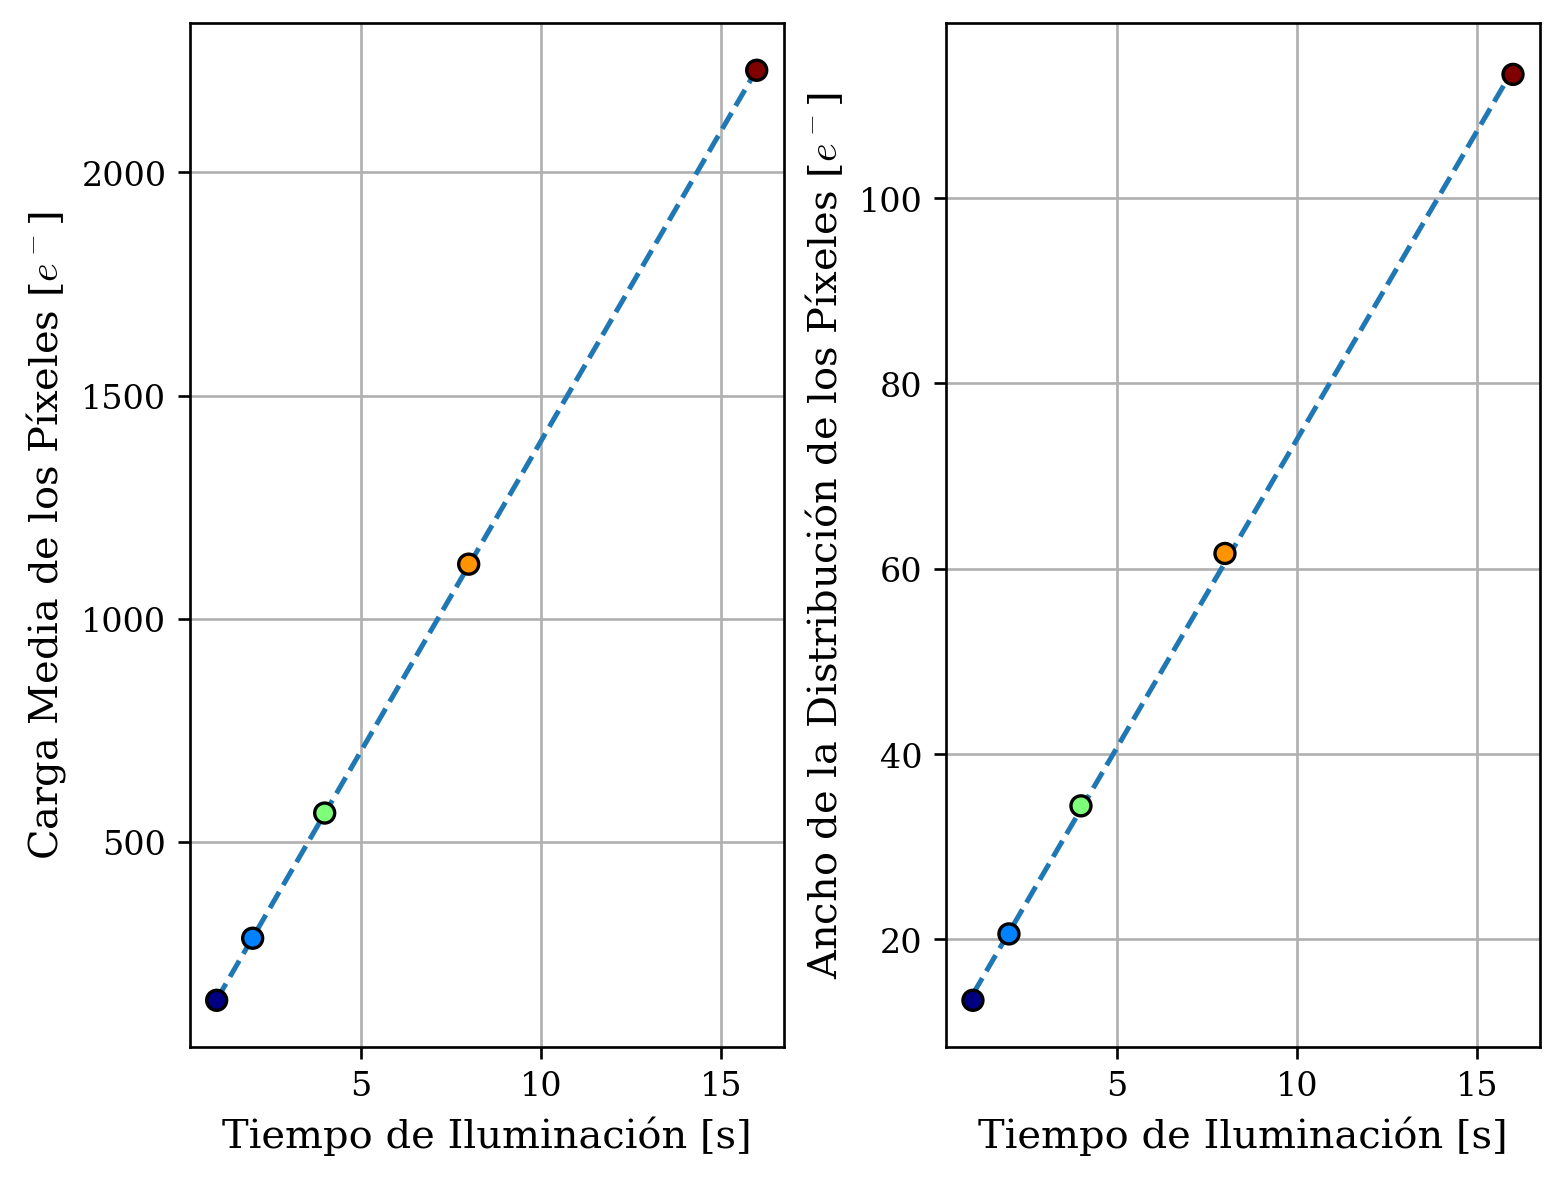

In [17]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

for ax, vals, tag in zip(axs, [carga_media, ancho_dist], ["Carga Media", "Ancho de la Distribución"]):
    vals = np.array(vals)
    ax.scatter(exposure_times, vals, c=np.log2(exposure_times), cmap="jet", edgecolors="k", zorder=10)
    popt, pcov = curve_fit(lambda x, a, b: a*x + b, exposure_times, vals)
    perr = np.sqrt(np.diag(pcov))
    print(tag)
    print(f"Pendiente: {popt[0]:.1f} ± {perr[0]:.1g} e⁻/s")
    print(f"Ordenada : {popt[1]:.1f} ± {perr[1]:.1g} e⁻")
    ax.plot(exposure_times, popt[0]*exposure_times + popt[1], linestyle="--", zorder=3)
    ax.grid(True)
    ax.set_xlabel("Tiempo de Iluminación [s]")
    ax.set_ylabel(f"{tag} de los Píxeles [$e^-$]")

# axs[-1].scatter(carga_media, ancho_dist, c=np.log2(exposure_times), cmap="jet", edgecolors="k", zorder=10)
# popt, pcov = curve_fit(lambda x, a, b: a*x + b, carga_media, ancho_dist)
# perr = np.sqrt(np.diag(pcov))
# print("Relación entre Carga Media y Ancho de la Distribución")
# print(f"Pendiente: {popt[0]:.1f} ± {perr[0]:.1g} e⁻/s")
# print(f"Ordenada : {popt[1]:.1f} ± {perr[1]:.1g} e⁻")
# axs[-1].plot(carga_media, popt[0]*np.array(carga_media) + popt[1], linestyle="--", zorder=3)
# axs[-1].grid(True)
# axs[-1].set_xlabel(f"Carga Media de los Píxeles [$e^-$]")
# axs[-1].set_ylabel(f"Ancho de la Distribución de los Píxeles [$e^-$]")
plt.show()

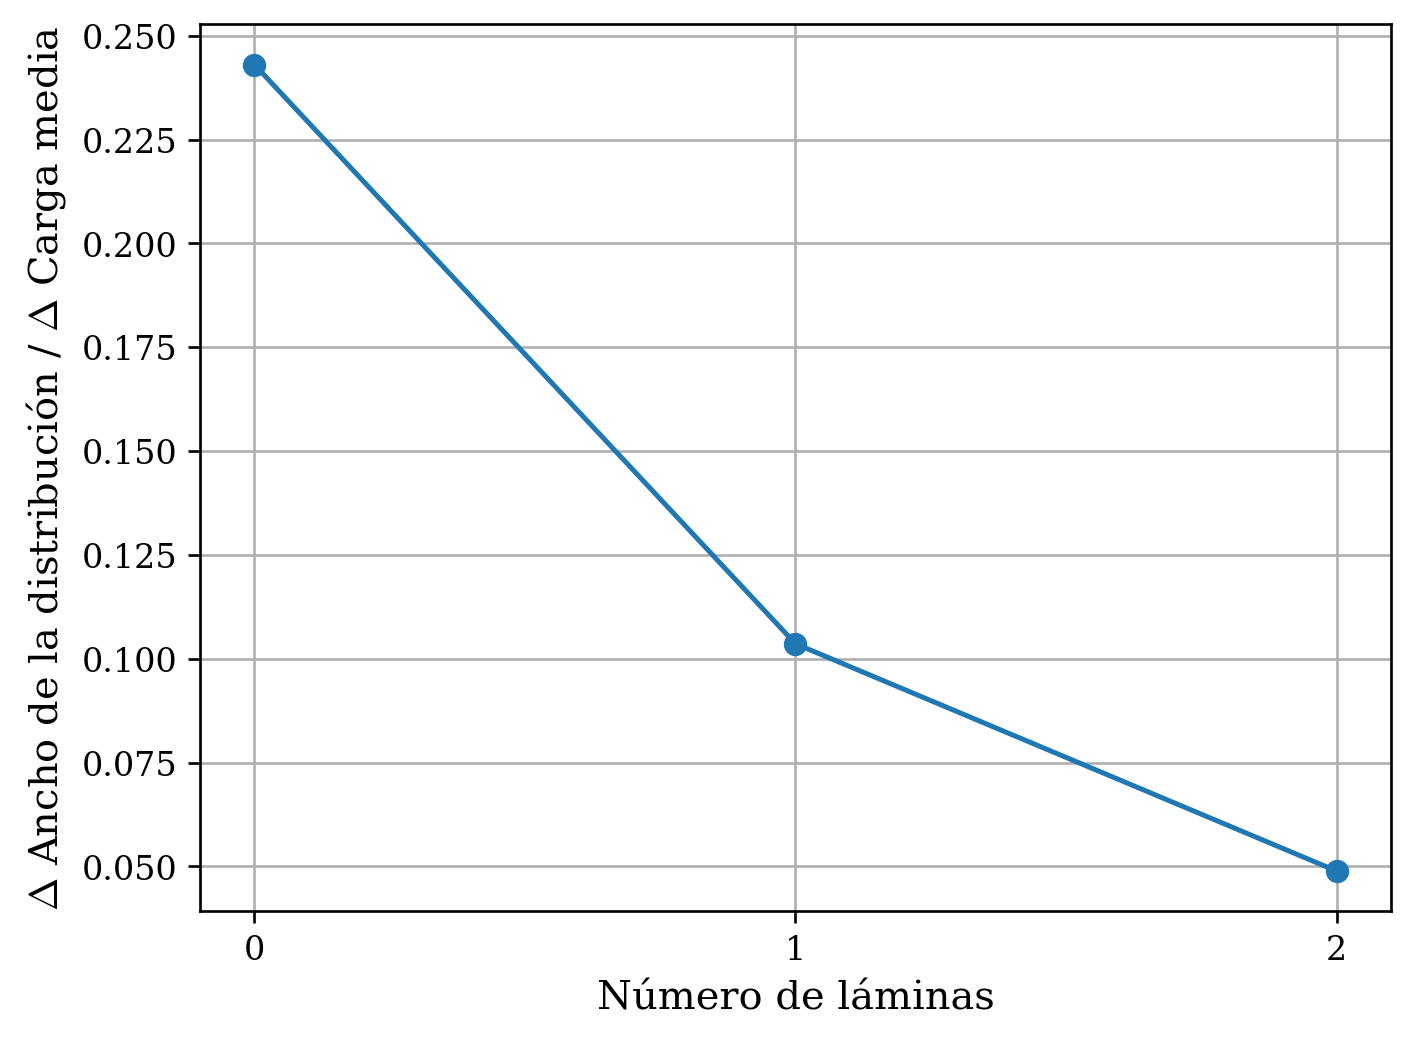

In [55]:
p_mean = [1654, 291.5, 116.6]
p_dist = [402, 30.2, 5.7]

p_optim = [std/avg for avg, std in zip(p_mean, p_dist)]

plt.plot(p_optim, "o-")
plt.grid()
plt.xlabel("Número de láminas")
plt.xticks([0, 1, 2])
plt.ylabel("$\Delta$ Ancho de la distribución / $\Delta$ Carga media")
plt.show()

# Estudio de homogeneidad

In [21]:
t_ilum = 0.25
lighted_image = fits.open(f'{data_dir}/{sgn_files[t_ilum]}')
lighted_image = correct_overscan(lighted_image)
background_image = fits.open(f'{data_dir}/{bkg_files[t_ilum]}')
background_image = correct_overscan(background_image)
test_frame = lighted_image[2].data
r_overscan, c_overscan = get_rowcol_ovserscan(lighted_image)
test_frame = test_frame[:-r_overscan, PRESCAN_PIX:-c_overscan]
homogeneidad_local_col = np.zeros_like(test_frame)
homogeneidad_local_row = np.zeros_like(test_frame)

for i in range(1, np.shape(test_frame)[0]-1 ):
    for j in range(1, np.shape(test_frame)[1]-1):
        grad_vertical = (
            +2*test_frame[i, j+1]- 2*test_frame[i, j-1] 
            +test_frame[i+1, j+1]+ test_frame[i-1, j+1]
            -test_frame[i+1, j-1]- test_frame[i-1, j-1] 
        )
        grad_horizontal = (
            +2*test_frame[i+1, j]- 2*test_frame[i-1, j] 
            +test_frame[i+1, j+1]+ test_frame[i+1, j-1]
            -test_frame[i-1, j+1]- test_frame[i-1, j-1] 
        )
        homogeneidad_local_col[i, j] = grad_vertical
        homogeneidad_local_row[i,j] = grad_horizontal
        

         


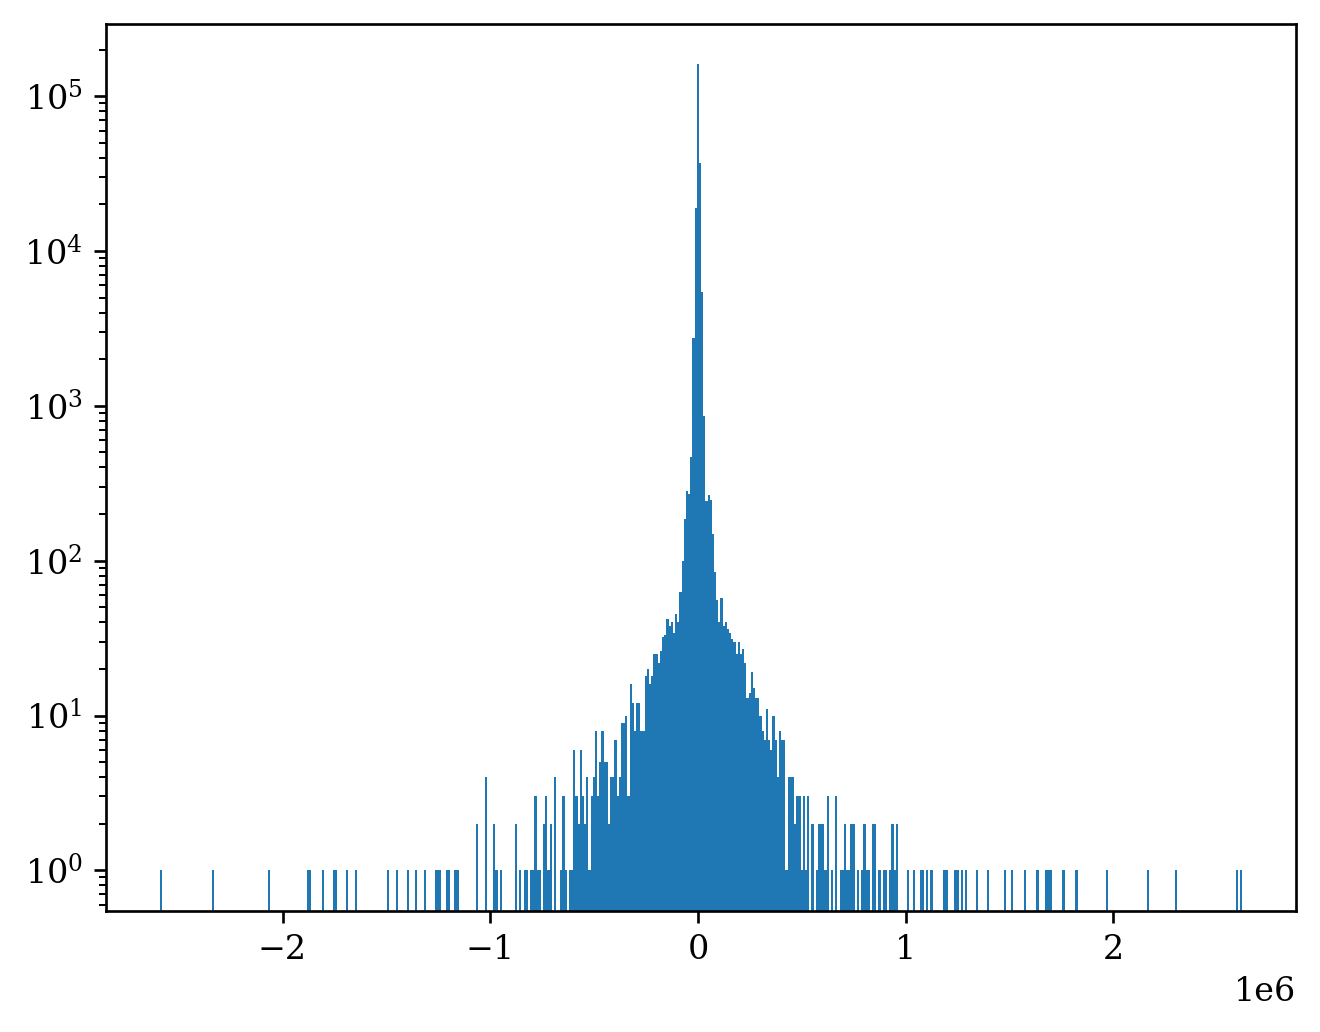

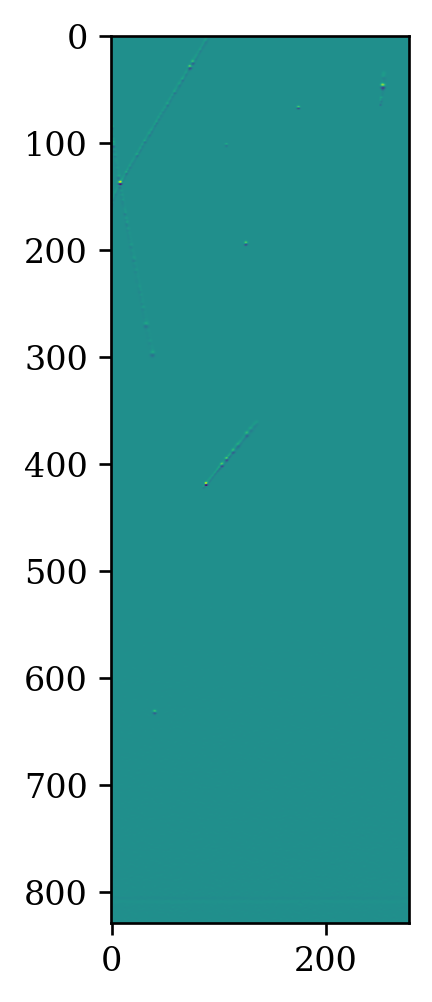

In [23]:
plt.hist(homogeneidad_local_row.flatten(), bins =500)
plt.yscale("log")
plt.show()
plt.imshow(homogeneidad_local_row)

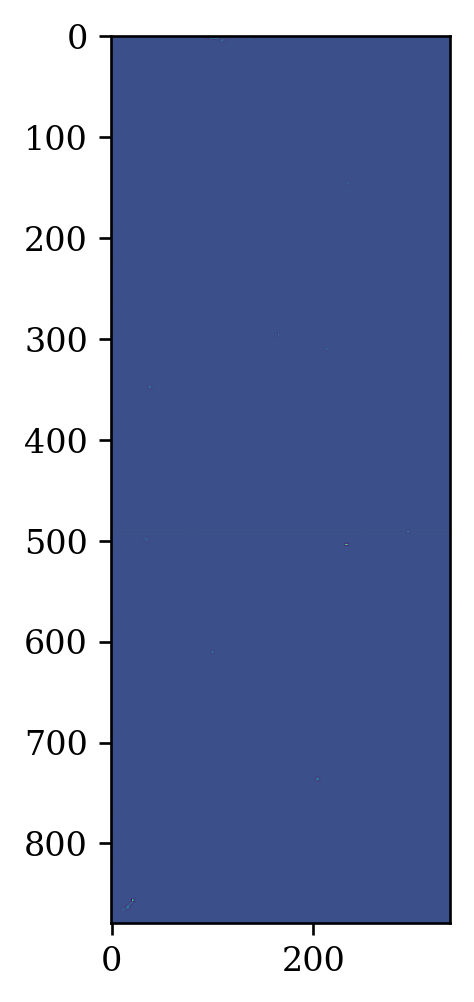

In [10]:
plt.imshow(homogeneidad_local)